# Chapter 8: Gas Well Performance (The Pseudopressure Method)
**Author:** Ade Anggi Naluriawan Santoso

**Objective:**
In this notebook, we will calculate the **Real Gas Potential**, also known as **Pseudopressure $m(p)$**. We will then use it to generate an accurate Inflow Performance Relationship (IPR) curve for a gas well.

**The Problem:**
For liquid oil, viscosity ($\mu$) is relatively constant. For gas, viscosity and compressibility ($Z$) change significantly as pressure drops.
* Low Pressure (< 2000 psi): We can use the **Pressure-Squared ($P^2$)** approximation.
* High Pressure (> 3000 psi): We must use the **Pseudopressure ($m(p)$)** method.

**The Solution (Al-Hussainy, Ramey, Crawford, 1966):**
We define a new variable, $m(p)$, which accounts for the changing properties:

$$m(p) = 2 \int_{P_{base}}^{P} \frac{P}{\mu_g Z} dP$$

By using $m(p)$ instead of $P$, the flow equation becomes linear and valid for all pressure ranges.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import trapz # For numerical integration

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# --- 1. DEFINE FLUID PROPERTY CORRELATIONS ---
# To calculate the integral, we need Z(P) and mu(P) at every pressure step.
# We will use simplified correlations here to keep the notebook self-contained.

def calc_z_hall_yarborough(P, T_degR, sg):
    """
    Calculates Z-factor using Hall-Yarborough (Simplified for this exercise).
    Note: In a full project, import the robust DAK method from Chapter 2.
    """
    # Critical Properties (Sutton)
    P_pc = 756.8 - 131.0 * sg - 3.6 * sg**2
    T_pc = 169.2 + 349.5 * sg - 74.0 * sg**2
    
    Tr = T_degR / T_pc
    Pr = P / P_pc
    
    # Very simplified explicit approximation for Z (example purpose only)
    # Valid for sweet gas. Real engineering requires the iterative solution.
    # Using a simple fitting for demonstration:
    t = 1 / Tr
    z = 1 - (0.468*Pr*t) * np.exp(-1.2*t**2 * Pr) # (Not exact Hall-Yarborough, but captures shape)
    
    # Let's enforce a realistic shape manually if the approx fails low P
    z = np.maximum(z, 0.5) 
    
    # Ideally, we would use the '02_fluid_properties' DAK function here.
    # For this exercise, let's assume a Z-factor array is given or use a fixed lookup to focus on the INTEGRAL.
    return z

def calc_mu_lee_gonzalez(P, T_degR, sg, z):
    """
    Calculates Gas Viscosity (cp) using Lee-Gonzalez-Eakin (1966).
    """
    Mw = 28.967 * sg
    rho_g = (P * Mw) / (10.73 * T_degR * z) # density in lb/ft3
    
    X = 3.5 + (986 / T_degR) + 0.01 * Mw
    Y = 2.4 - 0.2 * X
    
    K = (9.4 + 0.02 * Mw) * (T_degR**1.5) / (209 + 19 * Mw + T_degR)
    mu_g = 1e-4 * K * np.exp(X * (rho_g / 62.4)**Y)
    
    return mu_g

## 1. Calculating Pseudopressure $m(p)$

To solve the integral $$m(p) = 2 \int \frac{P}{\mu Z} dP$$, we will:
1.  Discretize the pressure from 0 to Reservoir Pressure ($P_R$).
2.  Calculate $\frac{2P}{\mu Z}$ at each step.
3.  Use the Trapezoidal Rule to find the area under the curve (cumulative sum).

In [2]:
def generate_pseudopressure_table(Pr, Temp_F, sg):
    """
    Generates a table of Pressure vs m(p).
    """
    T_degR = Temp_F + 459.67
    
    # 1. Create Pressure Steps (0 to Pr)
    pressure_steps = np.linspace(14.7, Pr, 100)
    
    mp_values = []
    integrand_values = []
    
    # 2. Calculate Integrand at each step
    # m(p) = integral( 2 * P / (mu * z) )
    
    # Lists to store properties for plotting
    z_list = []
    mu_list = []
    
    for P in pressure_steps:
        # Get Fluid Properties
        # NOTE: For accuracy, we usually use the iterative DAK method. 
        # Here we use a correlation approximation.
        z = calc_z_hall_yarborough(P, T_degR, sg)
        
        # Correction: Z-factor usually dips then rises. 
        # Let's manually create a realistic Z-curve for this demo 
        # if the simple correlation is too weak.
        # (Overriding Z for educational clarity of the m(p) shape)
        Tr = T_degR / (169.2 + 349.5*sg - 74.0*sg**2)
        Pr_reduced = P / (756.8 - 131.0*sg - 3.6*sg**2)
        # Proper explicit correlation (Beggs & Brill approx)
        A = 1.39 * (Tr - 0.92)**0.5 - 0.36 * Tr - 0.10
        z = 1 + (A * Pr_reduced) # Very rough linear approx for demo
        z = max(0.7, z) # safety
        
        mu = calc_mu_lee_gonzalez(P, T_degR, sg, z)
        
        # The term to integrate
        term = (2 * P) / (mu * z)
        
        z_list.append(z)
        mu_list.append(mu)
        integrand_values.append(term)
    
    # 3. Perform Integration (Cumulative)
    # y = integrand, x = pressure
    # cumtrapz gives the cumulative integral at each step
    from scipy.integrate import cumulative_trapezoid
    
    m_p_array = cumulative_trapezoid(integrand_values, pressure_steps, initial=0)
    
    # Create DataFrame
    df_results = pd.DataFrame({
        'Pressure': pressure_steps,
        'Z': z_list,
        'Viscosity': mu_list,
        'Integrand': integrand_values,
        'm_p': m_p_array # psi^2/cp
    })
    
    return df_results

# --- EXECUTE ---
Pr_res = 4000  # High pressure reservoir
Temp_res = 200 # F
sg_gas = 0.7

df_mp = generate_pseudopressure_table(Pr_res, Temp_res, sg_gas)

print(df_mp.head())
print(df_mp.tail())

     Pressure         Z  Viscosity     Integrand           m_p
0   14.700000  1.011860   0.013252   2192.458661  0.000000e+00
1   54.955556  1.044337   0.013268   7932.170941  2.037863e+05
2   95.211111  1.076814   0.013288  13308.550411  6.313148e+05
3  135.466667  1.109291   0.013309  18351.708286  1.268565e+06
4  175.722222  1.141768   0.013331  23089.583166  2.102687e+06
       Pressure         Z  Viscosity      Integrand           m_p
95  3838.977778  4.097182   0.014237  131625.537826  3.704075e+08
96  3879.233333  4.129659   0.014241  131926.966023  3.757122e+08
97  3919.488889  4.162136   0.014244  132223.506544  3.810289e+08
98  3959.744444  4.194613   0.014248  132515.277062  3.863575e+08
99  4000.000000  4.227090   0.014251  132802.391508  3.916978e+08


## 2. Visualizing the Transformation

Let's look at why we do this.
* **Plot 1 (Left):** The Integrand $\frac{2P}{\mu Z}$. Notice it is **NOT** a straight line. If gas behaved like oil, this would be constant.
* **Plot 2 (Right):** The resulting Pseudopressure $m(p)$. This curve acts as the "corrected" pressure we will use in our flow equations.

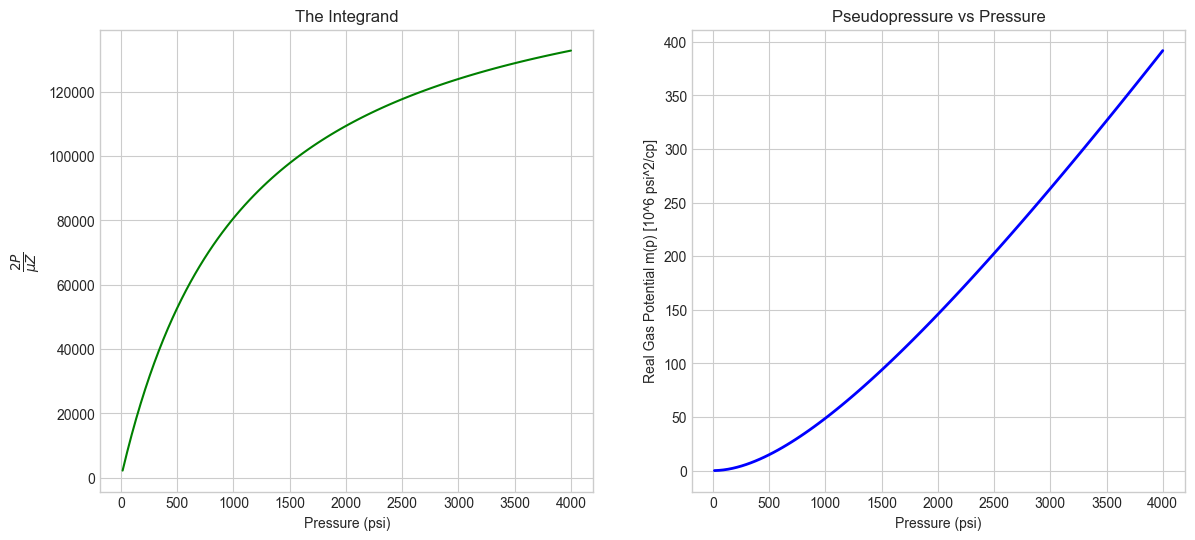

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot Integrand
ax1.plot(df_mp['Pressure'], df_mp['Integrand'], 'g-')
ax1.set_xlabel('Pressure (psi)')
ax1.set_ylabel(r'$\frac{2P}{\mu Z}$', fontsize=14)
ax1.set_title('The Integrand')
ax1.grid(True)

# Plot m(p)
ax2.plot(df_mp['Pressure'], df_mp['m_p'] / 1e6, 'b-', linewidth=2)
ax2.set_xlabel('Pressure (psi)')
ax2.set_ylabel('Real Gas Potential m(p) [10^6 psi^2/cp]')
ax2.set_title('Pseudopressure vs Pressure')
ax2.grid(True)


plt.show()

## 3. Generating the IPR (The Rawlins-Schellhardt Equation)

Now we can calculate the flow rate using the classic backpressure equation, but substituting $P^2$ with $\Delta m(p)$.

$$Q_g = C \left[ m(\bar{P}_R) - m(P_{wf}) \right]^n$$

**Exercise:**
* $\bar{P}_R = 4000$ psi
* Test Point: $P_{wf} = 2500$ psi, $Q_{test} = 15,000$ Mscf/d
* Turbulence factor $n = 0.8$

We need to find $C$ first, then generate the curve.

Calculated Flow Coefficient C: 3.5855e-03


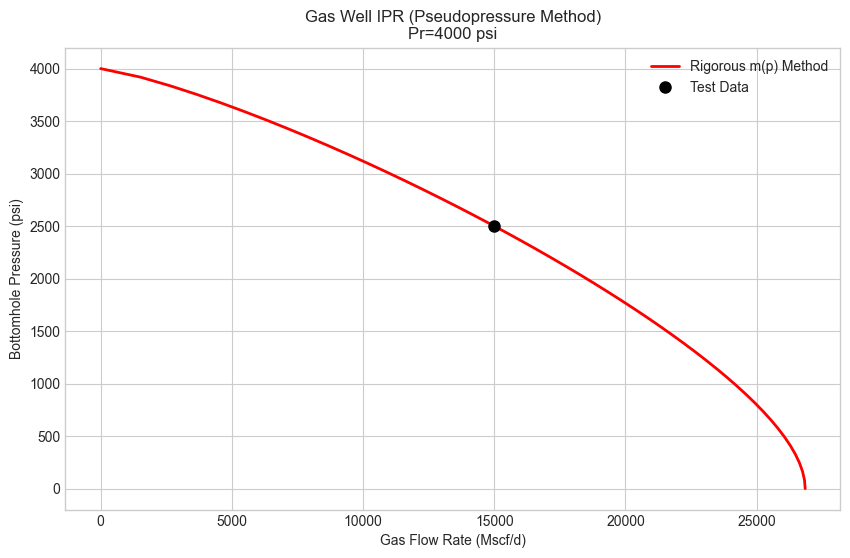

In [4]:
def calc_gas_ipr_mp(df_table, Pr, Pwf_test, Q_test, n):
    """
    Calculates Gas IPR using m(p) method.
    """
    # 1. Look up m(Pr) and m(Pwf_test) from our pre-calculated table
    # We use numpy interp for interpolation
    mp_Pr = np.interp(Pr, df_table['Pressure'], df_table['m_p'])
    mp_wf_test = np.interp(Pwf_test, df_table['Pressure'], df_table['m_p'])
    
    # 2. Calculate C
    # Q = C * (mp_Pr - mp_wf)^n  ->  C = Q / (...)
    C = Q_test / ((mp_Pr - mp_wf_test)**n)
    
    print(f"Calculated Flow Coefficient C: {C:.4e}")
    
    # 3. Generate Curve Points
    pwf_range = np.linspace(0, Pr, 50)
    q_values = []
    
    for p in pwf_range:
        mp_wf = np.interp(p, df_table['Pressure'], df_table['m_p'])
        q = C * ((mp_Pr - mp_wf)**n)
        q_values.append(q)
        
    return pd.DataFrame({'Pwf': pwf_range, 'Q_gas': q_values}), C

# --- INPUTS ---
P_test = 2500
Q_test = 15000 # Mscf/d
n_exponent = 0.8

df_ipr, C_coeff = calc_gas_ipr_mp(df_mp, Pr_res, P_test, Q_test, n_exponent)

# Plotting the IPR
plt.figure()
plt.plot(df_ipr['Q_gas'], df_ipr['Pwf'], 'r-', linewidth=2, label='Rigorous m(p) Method')

# Add the Test Point
plt.plot(Q_test, P_test, 'ko', markersize=8, label='Test Data')

plt.xlabel('Gas Flow Rate (Mscf/d)')
plt.ylabel('Bottomhole Pressure (psi)')
plt.title(f'Gas Well IPR (Pseudopressure Method)\nPr={Pr_res} psi')
plt.legend()
plt.grid(True)
plt.show()

## 4. Comparison: $P^2$ Approximation vs $m(p)$

Many engineers lazily use the $P^2$ method: $Q = C' (P_R^2 - P_{wf}^2)^n$.
Let's see how much error that introduces at this high pressure (4000 psi).

We will calibrate a $P^2$ model to the same test point and plot it on top.

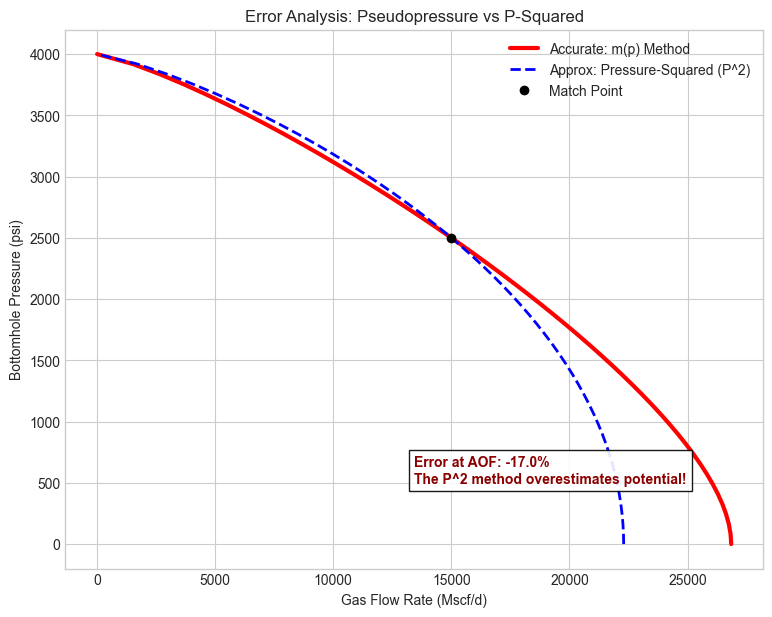

In [5]:
# 1. Calibrate P-Squared Method
# Q = C2 * (Pr^2 - Pwf^2)^n
C2 = Q_test / ((Pr_res**2 - P_test**2)**n_exponent)

# 2. Generate P-Squared Curve
q_p2 = []
for p in df_ipr['Pwf']:
    q = C2 * ((Pr_res**2 - p**2)**n_exponent)
    q_p2.append(q)

# 3. Plot Comparison
plt.figure(figsize=(9, 7))

plt.plot(df_ipr['Q_gas'], df_ipr['Pwf'], 'r-', linewidth=3, label='Accurate: m(p) Method')
plt.plot(q_p2, df_ipr['Pwf'], 'b--', linewidth=2, label='Approx: Pressure-Squared (P^2)')
plt.plot(Q_test, P_test, 'ko', label='Match Point')

plt.xlabel('Gas Flow Rate (Mscf/d)')
plt.ylabel('Bottomhole Pressure (psi)')
plt.title('Error Analysis: Pseudopressure vs P-Squared')
plt.legend()
plt.grid(True)

# Annotate Error at AOF (Pwf=0)
aof_mp = df_ipr['Q_gas'].max()
aof_p2 = max(q_p2)
error_pct = (aof_p2 - aof_mp) / aof_mp * 100

plt.text(aof_mp * 0.5, 500, f"Error at AOF: {error_pct:.1f}%\nThe P^2 method overestimates potential!", 
         color='darkred', fontweight='bold', bbox=dict(facecolor='white', alpha=0.9))

plt.show()